# Imports and Such

In [2]:
from functions.colours          import *
from functions.measurement      import *
from functions.optical_modes    import *
from functions.plotting         import *
from functions.propagation      import *

from LightPipes                 import *

import aotools
import cmath

pmap, imap, customColoursBGY, customColoursViridis = colours()

In [3]:
N=128
size=30*mm
beam_radius=size/4

wavelength=633*nm

F=Begin(size,wavelength,N)

# Code

Loaded DM phase profile of shape: (200, 200)


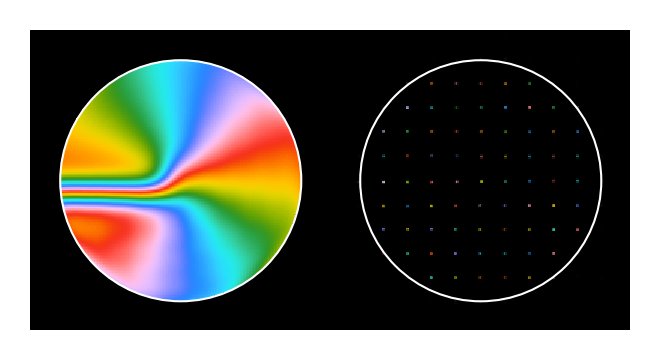

In [5]:
import numpy as np
from LightPipes import *
import matplotlib.pyplot as plt

# Import your custom functions
# Ensure your 'functions' folder is in the python path
from functions.colours import colours
# Assuming the plot_beam function is defined or imported in your notebook
# from your_plotting_script import plot_beam 

# 1. Setup Parameters (Must match DM_sim.py)
wavelength = 0.633 * um
size = 28 * mm
N = 200
pupil_diam = 22.5 * mm

# 2. Load the Smoothed CSV
try:
    dm_phase = np.loadtxt("dm_phase_profile.csv", delimiter=",")
    print(f"Loaded DM phase profile of shape: {dm_phase.shape}")
except FileNotFoundError:
    print("Error: Run the .py script and click 'Save CSV' first.")

# 3. Create Field and Apply DM Profile
F = Begin(size, wavelength, N)
F = CircAperture(F, pupil_diam/2)
F = SubPhase(F, dm_phase)

# 4. Far-field Propagation to see the Doughnut
F_far = Lens(F, 50 * cm)
F_far = Fresnel(F_far, 50*cm)

# 5. Use your custom plotting function
# We plot the Near-field (the DM surface) and the Far-field (the OAM doughnut)
fig = plot_beam([F, F_far], rows=1, aperature=pupil_diam/2, intensity=True, phase=True)
plt.show()

In [ ]:
plt.show(plot_beam(OAM(F,)))

Initialized DM with 97 actuators.


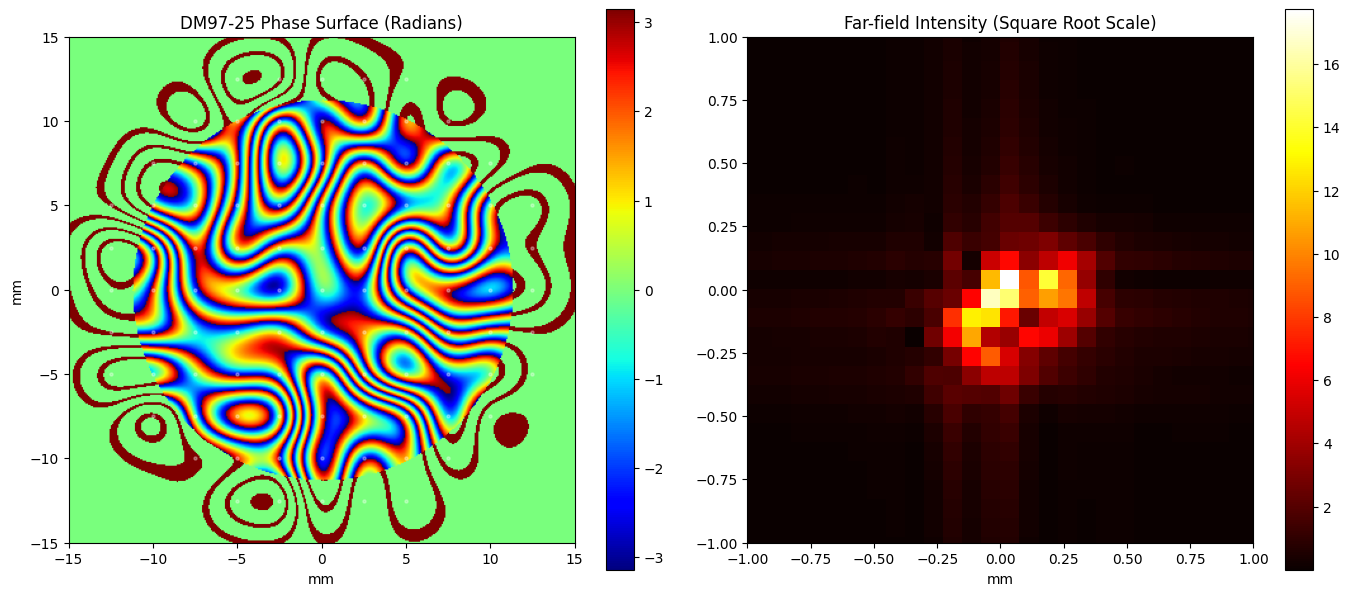

In [3]:
# --- 1. Physical Parameters (Based on DM97-25 Datasheet) ---
wavelength = 633 * nm          # Helium-Neon laser wavelength
size = 30 * mm                 # Grid size (must be larger than pupil)
N = 400                        # Grid resolution (NxN pixels)
pupil_diam = 22.5 * mm         # Active optical area
pitch = 2.5 * mm               # Distance between actuator centers
coupling = 0.25                # Mechanical coupling (25% is typical for ALPAO)

# --- 2. Initialize LightPipes Field ---
F = Begin(size, wavelength, N)
F = CircAperture(F, pupil_diam/2) # Primary pupil

# --- 3. Define Actuator Geometry ---
# Generate a grid and filter it to get the circular 97-actuator pattern
x_grid = np.linspace(-size/2, size/2, N)
y_grid = np.linspace(-size/2, size/2, N)
X, Y = np.meshgrid(x_grid, y_grid)

act_x, act_y = [], []
grid_indices = np.arange(-5, 6) # 11x11 grid potential

for i in grid_indices:
    for j in grid_indices:
        px, py = i * pitch, j * pitch
        # Radius check to match the 97-actuator count of the DM97
        if np.sqrt(px**2 + py**2) < 13.8 * mm:
            act_x.append(px)
            act_y.append(py)

act_x = np.array(act_x)
act_y = np.array(act_y)
num_actuators = len(act_x)

print(f"Initialized DM with {num_actuators} actuators.")

# --- 4. Define DM Function ---
def apply_dm_shape(field, commands_um):
    """
    Applies a continuous phase surface to the field.
    commands_um: array of 97 values representing displacement in microns.
    """
    # Calculate Gaussian width based on pitch and coupling
    # Formula: coupling = exp(-pitch^2 / (2 * sigma^2))
    sigma = pitch / np.sqrt(-2 * np.log(coupling))
    
    total_phase = np.zeros((N, N))
    
    for i in range(num_actuators):
        if commands_um[i] == 0: continue
        
        # Calculate distance from this actuator to every pixel
        r2 = (X - act_x[i])**2 + (Y - act_y[i])**2
        influence = np.exp(-r2 / (2 * sigma**2))
        
        # Phase = (2 * pi / lambda) * (2 * displacement) 
        # The extra factor of 2 accounts for the reflective double-path
        phi = (2 * np.pi * (2 * commands_um[i] * um)) / wavelength
        total_phase += influence * phi
        
    return SubPhase(field, total_phase)

# --- 5. Run Simulation ---
# Generate 97 random commands (between -0.5 and 0.5 microns)
# This simulates a "random" corrected or distorted state
np.random.seed(42) # For reproducibility
commands = np.random.uniform(-0.8, 0.8, num_actuators)

# Apply DM shape
F_dm = apply_dm_shape(F, commands)

# Propagate to far field (Focusing) to see the effect on the PSF
F_focus = Forvard(F_dm, 50 * cm) # Propagate 50cm
F_focus = Lens(F_focus, 50 * cm) # Focus
F_focus = Forvard(F_focus, 50 * cm)

# --- 6. Visualization ---
phase_map = Phase(F_dm)
intensity_map = Intensity(F_focus)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Phase Map
im1 = ax[0].imshow(phase_map, extent=[-size/2/mm, size/2/mm, -size/2/mm, size/2/mm], cmap='jet')
ax[0].scatter(act_x/mm, act_y/mm, color='white', s=5, alpha=0.3, label='Actuators')
ax[0].set_title("DM97-25 Phase Surface (Radians)")
ax[0].set_xlabel("mm")
ax[0].set_ylabel("mm")
plt.colorbar(im1, ax=ax[0])

# Plot Resulting Intensity (PSF)
im2 = ax[1].imshow(np.sqrt(intensity_map), extent=[-size/2/mm, size/2/mm, -size/2/mm, size/2/mm], cmap='hot')
ax[1].set_title("Far-field Intensity (Square Root Scale)")
ax[1].set_xlim(-1, 1) # Zoom into the focus
ax[1].set_ylim(-1, 1)
ax[1].set_xlabel("mm")
plt.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()